# Planetary Variables
## Land Surface Temperature
### Mapping Urban Temperature 

This Jupyter Notebook demonstrates how to map heatwave impact over cities based on the [Land Surface Temperature](https://docs.sentinel-hub.com/api/latest/data/planetary-variables/land-surface-temp/) product using Sentinel Hub's [Processing API](https://docs.sentinel-hub.com/api/latest/api/process/).

In this example, the number of days with an anomaly > 10&deg;C is calculated from the archive of Land Surface Temperature 100m: for the purpose of this demonstration, anomaly is considered as the difference between the LST and the climatology defined by the period requested (note that the period and the anomaly threshold can be changed in the script). 

This Notebook returns a raster dataset from Sentinel Hub's API before displaying the map

In [1]:
import json
import folium
import numpy as np

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

from sentinelhub import (
    SHConfig,
    geometry,
    CRS,
    SentinelHubStatistical,
    DataCollection,
    MimeType,
    SentinelHubRequest,
)

/Users/yoannmalbeteau/miniconda3/envs/sentinelhub/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Credentials

To obtain your `client_id` & `client_secret`, you need to navigate to your [Dashboard](https://apps.sentinel-hub.com/dashboard/#/). In the User Settings, you can create a new OAuth client to generate these credentials. More detailed instructions can be found on the corresponding [documentation page](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). This is useful as changes to the config class in your notebook are usually only temporary and by saving the configuration to your profile, you don't have to generate new credentials or overwrite/change the default profile every time you run or write a new Jupyter Notebook.

Currently, the following cell is set up in a way that you need to specify your `client_id` & `client_secret` when running it.


In [2]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

## Set collection IDS

The 100m [Land Surface Temperature](https://docs.sentinel-hub.com/api/latest/data/planetary-variables/land-surface-temp/) is available as subscriptions through Sentinel Hub's [TPDI](https://docs.sentinel-hub.com/api/latest/api/data-import/) service. Once the area of interest and variables are subscribed to, the data are then automatically imported into Sentinel Hub and available by specifying the Collection ID. 

In this example, we will use the collection IDs available from [Planet's Sandbox Data page for Land Surface Temperature](https://collections.sentinel-hub.com/land-surface-temperature/sandbox-data.html). 

A collection ID will allow you to retrieve the data from the collection, just as you would with a standard dataset (e.g. Sentinel-2). For more information on how to call a collection ID in a request with Python, you can refer to the `sentinelhub-py` [documentation](https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html#Retrieve-data-from-collection).

In [3]:
collection_id= "8d977093-cf9e-4351-8159-90f2522c29c1"

## Area of Interest

First, we define an area of interest: The city of Bordeaux in France.

In this example, the area of interest is defined as a GeoJSON file in EPSG:4326. We will read the geoJSON and plot the area of interest on an interactive map.

You can also explore the area of interest in Sentinel Hub's [EO Browser](https://sentinelshare.page.link/EeYH). 

In [4]:
# Read a geojson containing a polygon representing a parcel of interest
parcel_data = json.loads(open("bordeaux.geojson").read())
parcel_polygon = Polygon(parcel_data["features"][0]["geometry"]["coordinates"][0][0])

# Convert to a Sentinel Hub geometry
parcel_geo = geometry.Geometry(parcel_polygon, crs=CRS(4326))

del parcel_data

In [5]:
# Plot the parcel on an interactive map
m = folium.Map(
    location=[
        parcel_polygon.centroid.coords.xy[1][0],
        parcel_polygon.centroid.coords.xy[0][0],
    ],
    zoom_start=11,
    tiles="OpenStreetMap",
)
geo_j = folium.GeoJson(data=parcel_polygon, style_function=lambda x: {"fillColor": "blue"})
geo_j.add_to(m)
m

## Compute the number of days with high anomaly positive

In the following step, we will use Sentinel Hub's Processing API to retrieve the number of days with anomaly > 10&deg;C at 13.30 over the city of Bordeaux between the month of June and September.

In [6]:
sensingTime = "1330" # Solar local time
LST_threshold = 10 # temperature threshold in degrees Celsius/Kelvin
min_month = 7 # July
max_month = 9 # September

In [18]:
count_evalscript = f"""
//VERSION=3
const sensingTime = {sensingTime}

const NODATA = NaN;
const band = "LST";

function setup() {{
    return {{
        input: [band, "dataMask"],
        output: {{ id: "anomalyCount", bands: 1, sampleType: "INT16" }},
        mosaicking: "TILE",
    }};
}}

function sortDatesDescending(d1, d2) {{
    const date1 = new Date(d1.date);
    const date2 = new Date(d2.date);
    return date2 - date1;
}}

function preProcessScenes(collections) {{
    let scenes = collections.scenes.tiles.filter(function (tile) {{
        let date = new Date(tile.date);
        let month = date.getMonth();
        return tile.dataPath.includes("T" + sensingTime) && month >= {min_month} && month <= {max_month};
    }});
    scenes = scenes.sort(sortDatesDescending);
    collections.scenes.tiles = scenes;
    return collections;
}}

function calculateAnomaly(data) {{
    let grouped = {{}};
    for (let i = 0; i < data.length; i++) {{
        let date = new Date(data[i].date);
        let doy = Math.floor((date - new Date(date.getFullYear(), 0, 0)) / 1000 / 60 / 60 / 24);
        if (!grouped[doy]) {{
            grouped[doy] = [];
        }}
        if (data[i].dataMask) {{
            grouped[doy].push(data[i].LST/100);
        }}
    }}

    let averages = {{}};
    for (let doy in grouped) {{
        let sum = grouped[doy].reduce((a, b) => a + b, 0);
        averages[doy] = sum / grouped[doy].length;
    }}

    let anomalies = data.map(item => {{
        let date = new Date(item.date);
        let doy = Math.floor((date - new Date(date.getFullYear(), 0, 0)) / 1000 / 60 / 60 / 24);

        anomaly=(item.LST/100) - averages[doy];
    
        return {{
            anomaly_LST: anomaly,
            climatology: averages[doy],
        }};
    }});

    let anomalyCount = 0;
    for (let i = 0; i < anomalies.length; i++) {{
          if (anomalies[i].anomaly_LST > {LST_threshold}) {{
              anomalyCount++;
      }}
    }}
    return anomalyCount;
}}

function evaluatePixel(samples) {{
    let anomalyCount = calculateAnomaly(samples);
    return [anomalyCount];
}}
"""

### Prepare the request

We build the request according to the [API Reference](https://docs.sentinel-hub.com/api/latest/api/process/), using the `SentinelHubRequest` class from the `sentinelhub-py` [Python package](https://sentinelhub-py.readthedocs.io/en/latest/index.html). Each Process API request also needs an [evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/v3/). 

In [19]:
# Payload
request_anomaly_count = SentinelHubRequest(
    evalscript=count_evalscript,
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.define_byoc(collection_id),
            time_interval=(f"2017-07-01", f"2022-12-31"),
        ),
    ],
    responses=[SentinelHubRequest.output_response("anomalyCount", MimeType.TIFF)],
    geometry=parcel_geo,
    resolution=(0.001, 0.001),
    data_folder=".",
    config=config,
)

# Run the request
anomaly_count_data = request_anomaly_count.get_data()

### Plot results

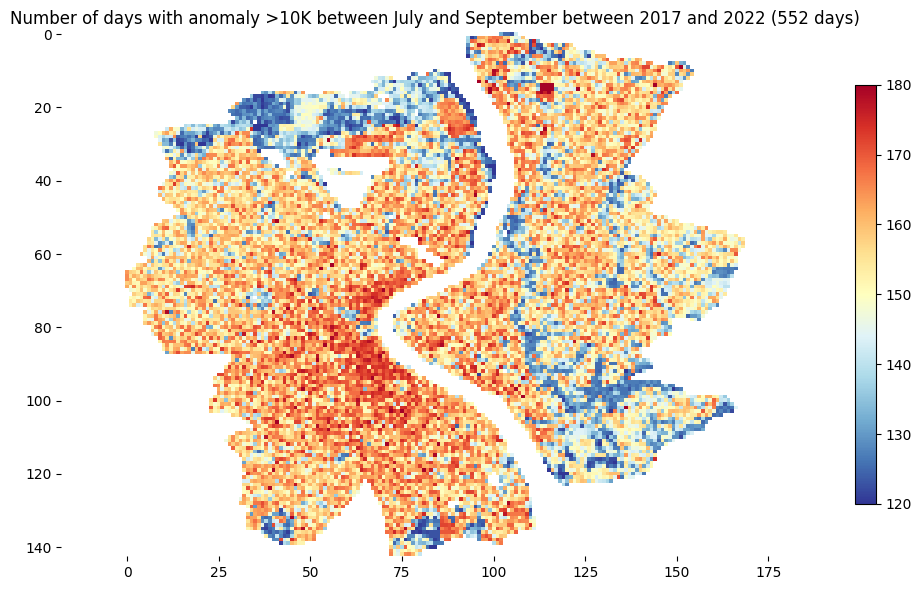

In [32]:
masked_data = np.ma.masked_where(anomaly_count_data[0] == 0, anomaly_count_data[0])

fig, ax = plt.subplots(figsize=(10, 6))  # Width=10, Height=6
plt.imshow(masked_data, cmap="RdYlBu_r", vmin=120, vmax=180)
plt.title(f"Number of days with anomaly >{LST_threshold}K between July and September between 2017 and 2022 (552 days)")
plt.tight_layout
plt.colorbar(orientation='vertical', shrink=0.8)

ax.axis('equal')
ax.set_frame_on(False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()